In [8]:
# importing the libraries
import pylab
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import math
import librosa
import librosa.display
import tensorflow as tf
import glob
import os
% matplotlib inline

In [18]:

# returns the window size for the given signal 
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)# similar to return but outputs only when the loop stops 
        start += (window_size / 2)# two sided window

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            #print(fn.split('/'))
            label = fn.split('/')[3].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)# to be explained 
                    logspec = librosa.logamplitude(melspec)# to be explained
                    logspec = logspec.T.flatten()[:, np.newaxis].T# to be explained
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode


In [19]:
parent_dir = 'sound-Data/audio'
sub_dirs= ['fold1','fold2']
features,labels = extract_features(parent_dir,sub_dirs)
labels = one_hot_encode(labels)

/Users/shanraja/anaconda3/envs/dog-project/lib/python3.5/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


In [23]:
features.shape
#labels.shape

(10834, 60, 41, 2)

In [41]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1], padding='SAME')

def apply_convolution(x,kernel_size,num_channels,depth):
    weights = weight_variable([kernel_size, kernel_size, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))

def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1], 
                          strides=[1, stride_size, stride_size, 1], padding='SAME')
#def normal_full_layer(x,size):
    

In [42]:
rnd_indices = np.random.rand(len(labels)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

In [38]:
train_x.shape

(7584, 60, 41, 2)

In [52]:
frames = 41
bands = 60

feature_size = 2460 #60x41
num_labels = 10
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 64
num_hidden =1024

learning_rate = 0.01
training_iterations = 2000

In [93]:
X = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])
print(X.shape)
conv1 = apply_convolution(X,kernel_size=30,num_channels=2,depth=32)
conv1_pooling=apply_max_pool(conv1,kernel_size=3,stride_size=1)
conv2=apply_convolution(conv1_pooling,kernel_size=5,num_channels=32,depth=64)
conv2_pooling=apply_max_pool(conv2,kernel_size=2,stride_size=1)





shape = conv2_pooling.get_shape().as_list()
print(shape)
cov_flat = tf.reshape(conv2_pooling, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * depth, num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.sigmoid(tf.add(tf.matmul(cov_flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

(?, 60, 41, 2)
[None, 15, 11, 64]


In [94]:
cross_entropy = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Test accuracy:  0.136


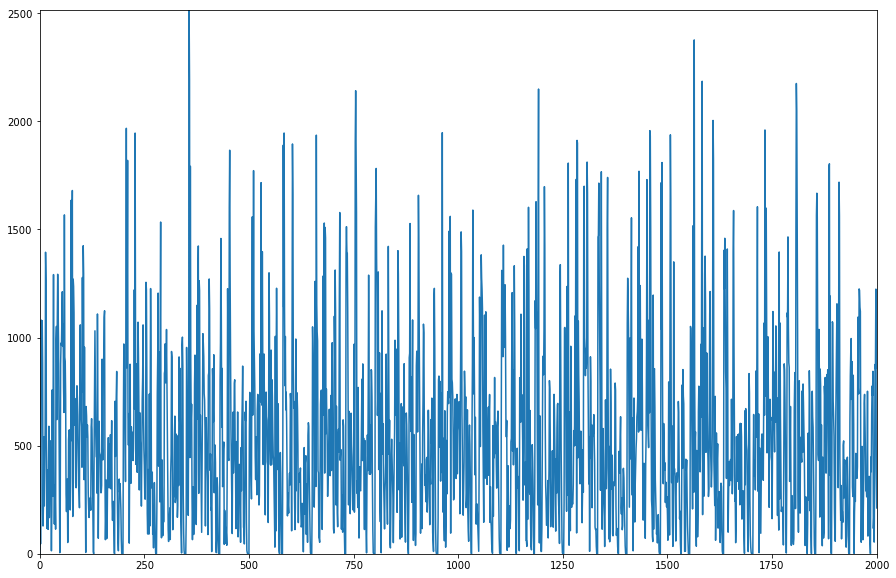

In [95]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    tf.global_variables_initializer().run()

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c = session.run([optimizer, cross_entropy],feed_dict={X: batch_x, Y : batch_y})
        cost_history = np.append(cost_history,c)
    
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y}) , 3))
    fig = plt.figure(figsize=(15,10))
    plt.plot(cost_history)
    plt.axis([0,training_iterations,0,np.max(cost_history)])
    plt.show()